# Affine transforms
This notebook demonstrates how to apply affine transforms to 3D images.

In [1]:
import pyclesperanto_prototype as cle

cle.select_device('RTX')

<Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.io import imshow

# Helper function for reading ImageJs ZIP file examples
import requests
import zipfile
from io import BytesIO
from tifffile import imread

def remote_reader(url):
    """generator that returns the first numpy arrays representing 
    in a tif in a remote zip."""
    response = requests.get(url)
    response.raise_for_status()
    with zipfile.ZipFile(BytesIO(response.content)) as zf:
        for path in zf.filelist:
            with zf.open(path, "r") as f:
                # f is a file-like object of type zipfile.ZipExtFile
                # replace imread with any file-reader of your choice
                # that accepts a file-like object as input 
                return imread(f)

In [3]:
# Laod example data
np_array = remote_reader('https://imagej.nih.gov/ij/images/t1-head.zip')

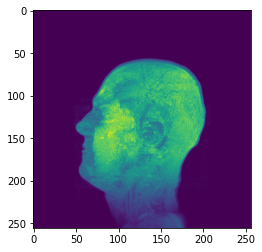

In [4]:
# push it to GPU memory
input_image = cle.push_zyx(np_array)

cle.imshow(input_image)

## Rotation
For rotating an image, you need to provide angles corresponding to axes.

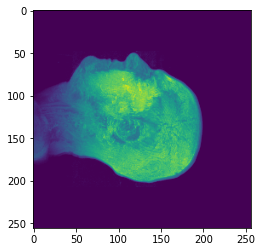

In [5]:
rotated = cle.rotate(input_image, angle_around_z_in_degrees=90)
cle.imshow(rotated)

Images are rotated around their center by default. You can change this by providing an additional parameter. The image will then be rotated around the origin.

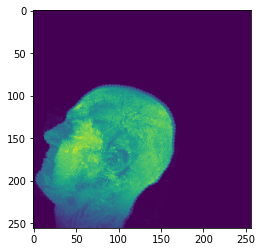

In [6]:
rotated = cle.rotate(input_image, angle_around_z_in_degrees=15, rotate_around_center=False)
cle.imshow(rotated)

## Translation
Images can be translate by providing translation distances along axes:

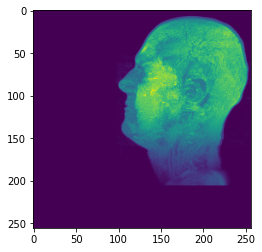

In [7]:
translated = cle.translate(input_image, translate_x=50, translate_y=-50)
cle.imshow(translated)

## Scaling
You can scale the image by providing scaling factors.

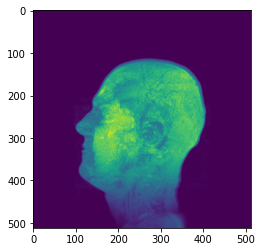

In [8]:
scaled = cle.scale(input_image, factor_x=2, factor_y=2)
cle.imshow(scaled)

## Rigid transform
Rigid transforms allow to do translations and rotations in one shot

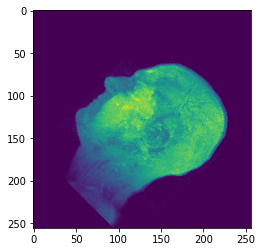

In [9]:
rigid_transformed = cle.rigid_transform(input_image, translate_x=20, angle_around_z_in_degrees=45)
cle.imshow(rigid_transformed)

## Affine transforms
To do translation, rotation and scaling in one shot, use affine transforms. [Shearing will be implemented in a future release](https://github.com/clEsperanto/pyclesperanto_prototype/issues/90).

To setup an affine transform, you can do this using a 4x4 transform matrix:

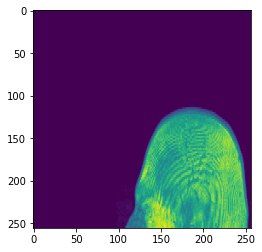

In [10]:
transform_matrix = np.asarray([
    [1, 0, 0, 50],
    [0, 2, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])
transformed_image = cle.affine_transform(input_image, transform=transform_matrix)
cle.imshow(transformed_image)

Alternatively, you can configure a transform object and pass it:

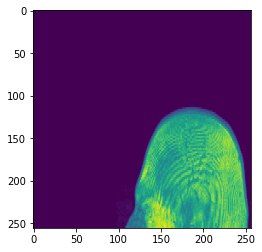

In [11]:
transform = cle.AffineTransform3D()
transform.translate(50)
transform.scale(1, 2, 0.5)

transformed_image = cle.affine_transform(input_image, transform=transform)
cle.imshow(transformed_image)

# Interoperability with scikit-image
Scikit-image only supports 2D transforms and thus, we pick a slice to transform it:

C:\Programs\miniconda3\envs\beetlesafari\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


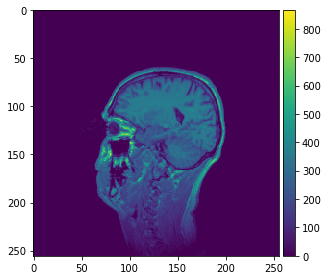

In [12]:
# pull image stack from GPU and pick a slice
image = cle.pull_zyx(input_image)[80]

from skimage.io import imshow
imshow(image)

We now define an affine transform using scikit-image and apply it to the image.

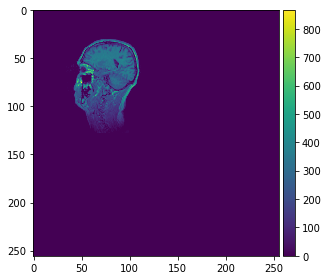

In [13]:
from skimage import transform as tf

# define transform with #scikit image
transform = tf.AffineTransform(scale=0.5, translation=[10,0])

transformed_image = tf.warp(image, transform.inverse)
imshow(transformed_image)

Next, we push this single plane image to the GPU and transform it using pyclesperanto

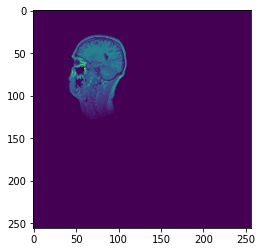

In [14]:
image_gpu = cle.push_zyx(image)

# define transform with #scikit image
from skimage import transform as tf
transform = tf.AffineTransform(scale=0.5, translation=[10,0])

transformed_image = cle.affine_transform(image_gpu, transform=transform)
cle.imshow(transformed_image)

# Interoperability with scipy
Affine transforms in scipy are applied in a similar way. Thus, APIs are similar. Let's start with translation, which is called `shift()` in scipy. The `shift` parameter takes the translation vector in `[z, y, x]`:

In [15]:
import scipy

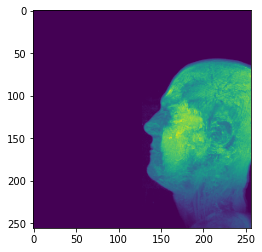

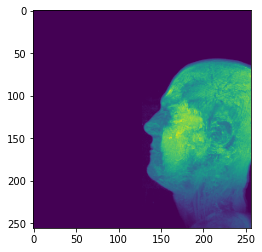

In [16]:
cle.imshow(scipy.ndimage.shift(np_array, shift=[0, 0, 80]))
cle.imshow(          cle.shift(np_array, shift=[0, 0, 80]))

Analogously, the rotate function can be used. The provided dimensions in the axes array are 0=z, 1=y, 2=x:

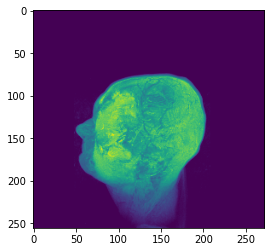

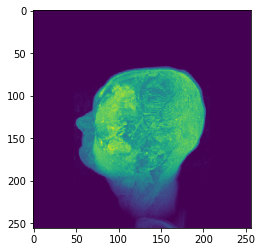

In [17]:
cle.imshow(scipy.ndimage.rotate(np_array, angle=45, axes=[0, 1]))
cle.imshow(          cle.rotate(np_array, angle=45, axes=[0, 1]))

`zoom()` can be used in the same way. Also here, `zoom` factors are provided as `[z,y,x]` array, or alternatively, as a single number for isotropic scaling:

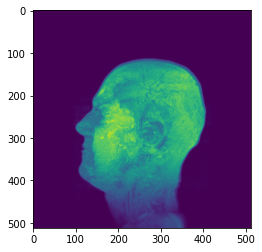

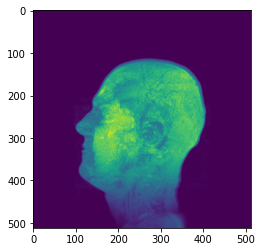

In [18]:
cle.imshow(scipy.ndimage.zoom(np_array, zoom=2))
cle.imshow(          cle.zoom(np_array, zoom=2))

Last but not least, affine transform matrices can be passed like this:

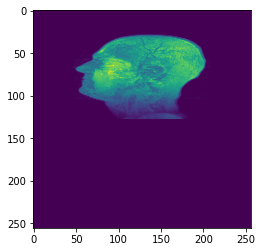

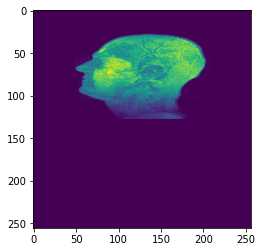

In [19]:
matrix = np.asarray([
    [1, 0, 0, 50],
    [0, 2, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
cle.imshow(scipy.ndimage.affine_transform(np_array, matrix=matrix))
cle.imshow(          cle.affine_transform(np_array, matrix=matrix))